In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

if os.getcwd() == '/Users/cd8607/Documents/Fitting_Potential':
    pass
else:
    os.chdir('../')
    
class ZBL():

    def __init__(self, Zi, Zj):
        
        self.Zi = Zi
        self.Zj = Zj

        e0 = 55.26349406e-4

        K = 1/(4*np.pi*e0)

        self.a = 0.46850/(self.Zi**0.23 + self.Zj**0.23)	

        self.amplitude = np.array([0.18175, 0.50986, 0.28022, 0.02817])
        self.exponent = np.array([3.19980, 0.94229, 0.40290, 0.20162])

        self.constant = K*Zi*Zj

    def eval_zbl(self, rij):

        if isinstance(rij, (int, float)):
            rij = np.array([rij])

        x = rij/self.a

        x = x[:, np.newaxis]

        phi = np.sum(self.amplitude * np.exp(-self.exponent * x), axis=1)
            
        return (self.constant/rij)*phi

    def eval_grad(self, rij):

        if isinstance(rij, (int, float)):
            rij = np.array([rij])

        x = rij/self.a

        x = x[:, np.newaxis]

        phi = np.sum(self.amplitude * np.exp(-self.exponent * x), axis=1)
        
        dphi = np.sum(-self.amplitude*self.exponent * np.exp(-self.exponent * x), axis=1)

        return (self.constant/rij)*(dphi/self.a - phi/rij)
    
    def eval_hess(self, rij):

        if isinstance(rij, (int, float)):
            rij = np.array([rij])
            
        x = rij/self.a

        x = x[:, np.newaxis]

        phi = np.sum(self.amplitude * np.exp(-self.exponent * x), axis=1)
        
        dphi = np.sum(-self.amplitude*self.exponent * np.exp(-self.exponent * x), axis=1)

        d2phi = np.sum(self.amplitude*self.exponent**2 * np.exp(-self.exponent * x), axis=1)

        return (self.constant/rij)*(d2phi/self.a**2 - 2*dphi/(self.a*rij) + 2*phi/rij**2)

In [3]:

def polyval(x, coef = None, dof = None):

    if coef is None:
        return np.array([x**i for i in range(dof)]).T
    
    else:
        dof = len(coef)
        phi = np.array([x**i for i in range(dof)]).T

        if phi.ndim == 1:
            return np.dot(phi, coef)
        else:
            return np.dot(phi, coef.reshape(-1,1)).flatten()

def linalg_solve(A, b):

    if A.shape[0] == A.shape[1]:

        return np.linalg.solve(A,b)

    else:
        return 

def d_polyval(x, coef = None, dof = None):

    if coef is None:
        return np.array([i*x**np.clip(i-1, a_min=0, a_max=None) for i in range(dof)]).T
    
    else:
        dof = len(coef)
        phi = np.array([i*x**np.clip(i-1, a_min=0, a_max=None) for i in range(dof)]).T

        if phi.ndim == 1:
            return np.dot(phi, coef)
        else:
            return np.dot(phi, coef.reshape(-1,1)).flatten()
         
def d2_polyval(x, coef = None, dof = None):

    if coef is None:
        return np.array([i*(i-1)*x**np.clip(i-2, a_min=0, a_max=None) for i in range(dof)]).T
    
    else:
        dof = len(coef)
        phi = np.array([i*(i-1)*x**np.clip(i-2, a_min=0, a_max=None) for i in range(dof)]).T

        if phi.ndim == 1:
            return np.dot(phi, coef)
        else:
            return np.dot(phi, coef.reshape(-1,1)).flatten()
        
def spline_eval(x, coef_lst, knots):

    # n = len(knots)

    # lower_bound = knots[np.arange(n-1)]
    # upper_bound = knots[np.arange(1,n)]

    # masks = np.array( [( (lower_bound[i] <= x) & (x < upper_bound[i]) ).astype(int) for i in range(n-1)])
    
    # return np.sum( np.array([ masks[i]*(polyval(x, coef = coef_lst[i])) for i in range(n-1)]), axis = 0)

    dr = knots[1] - knots[0]

    idx = np.floor(x/dr).astype(int)

    y = np.zeros((len(x),))

    for i in range(len(x)):
        
        if idx[i] < len(knots) - 1:

            x_norm = (x[i] - knots[idx[i]])/dr

            y[i] = polyval( x_norm, coef_lst[idx[i]])
        
        else:

            y[i] = 0
    
    return y

def spline_fit(x_arr, y_arr, n_knots, init_grad = None, final_grad = None):

    #At x = 0, y = 0, dy = 0, d2y = 0

    dof = 4

    coef_lst = []

    if init_grad is None:

        dof = 2

        # x = x_arr[[0,1]]

        x = np.array([0,1])

        Y = y_arr[[0,1]]

        Phi = polyval(x, coef = None, dof=dof)

        coef = np.linalg.solve(Phi, Y)

        coef_lst.append(coef)
    
    else:

        dof = 4

        # x = x_arr[0]

        x = 0

        phi_y = polyval(x, coef = None, dof=dof)

        phi_dy = d_polyval(x, coef = None, dof=dof)

        phi_d2y = d2_polyval(x, coef = None, dof=dof)

        # x = x_arr[1]

        x = 1

        phi_y1 = polyval(x, coef = None, dof=dof)

        Phi = np.vstack([phi_y, phi_dy, phi_d2y, phi_y1])

        Y = np.hstack([y_arr[0], init_grad[0], init_grad[1], y_arr[1]])

        coef = np.linalg.solve(Phi, Y)

        coef_lst.append(coef)
    
    dof = 4

    for j in range(1, n_knots-2):

        # x = x_arr[j]

        x = 0

        phi_y = polyval(x, coef = None, dof=dof)

        phi_dy = d_polyval(x, coef = None, dof=dof)

        phi_d2y = d2_polyval(x, coef = None, dof=dof)

        # x = x_arr[j + 1]

        x = 1

        dy = d_polyval(x, coef = coef_lst[-1])

        d2y = d2_polyval(x, coef = coef_lst[-1])

        phi_y1 = polyval(x, coef = None, dof=dof)

        Phi = np.vstack([phi_y, phi_dy, phi_d2y, phi_y1])

        Y = np.hstack([y_arr[j], dy, d2y, y_arr[j + 1]])

        coef = np.linalg.solve(Phi, Y)
        
        coef_lst.append(coef)
    
    if final_grad is None:

        dof = 4

        x = 0

        phi_y = polyval(x, coef = None, dof=dof)

        phi_dy = d_polyval(x, coef = None, dof=dof)

        phi_d2y = d2_polyval(x, coef = None, dof=dof)

        # x = x_arr[j + 1]

        x = 1

        dy = d_polyval(x, coef = coef_lst[-1])

        d2y = d2_polyval(x, coef = coef_lst[-1])

        phi_y1 = polyval(x, coef = None, dof=dof)

        Phi = np.vstack([phi_y, phi_dy, phi_d2y, phi_y1])

        Y = np.hstack([y_arr[j], dy, d2y, y_arr[j + 1]])

        coef = np.linalg.solve(Phi, Y)
        
        coef_lst.append(coef)
        
    else:

        dof = 6

        # x = x_arr[n_knots - 2]

        x = 0

        phi_y = polyval(x, coef = None, dof=dof)

        phi_dy = d_polyval(x, coef = None, dof=dof)

        phi_d2y = d2_polyval(x, coef = None, dof=dof)

        # x = x_arr[j + 1]

        x = 1

        dy = d_polyval(x, coef = coef_lst[-1])

        d2y = d2_polyval(x, coef = coef_lst[-1])

        phi_y1 = polyval(x, coef = None, dof=dof)

        phi_dy1 = d_polyval(x, coef = None, dof=dof)

        phi_d2y1 = d2_polyval(x, coef = None, dof=dof)

        Phi = np.vstack([phi_y, phi_dy, phi_d2y, phi_y1, phi_dy1, phi_d2y1])

        Y = np.hstack([y_arr[n_knots - 2], dy, d2y, y_arr[n_knots - 1], final_grad[0], final_grad[1]])

        coef = np.linalg.solve(Phi, Y)

        coef_lst.append(coef)
    
    return coef_lst

def polyfit(x, y, init_grad = None, final_grad=None):

    if init_grad is None and final_grad is None:

        dof = len(x)

        phi = polyval(x, coef = None, dof=dof)  

        return np.linalg.solve(phi, y)

    elif init_grad is not None and final_grad is None:

        dof = len(x) + 2

        phi_y = polyval(x, coef = None, dof=dof)

        phi_dy = d_polyval(x[0], coef = None, dof=dof)

        phi_d2y = d2_polyval(x[0], coef = None, dof=dof)

        phi = np.vstack([phi_y, phi_dy, phi_d2y])

        Y = np.hstack([y, init_grad])

        return np.linalg.solve(phi, Y)
    
    elif init_grad is None and final_grad is not None:

        dof = len(x) + 2

        phi_y = polyval(x, coef = None, dof=dof)

        phi_dy = d_polyval(x[-1], coef = None, dof=dof)

        phi_d2y = d2_polyval(x[-1], coef = None, dof=dof)

        phi = np.vstack([phi_y, phi_dy, phi_d2y])

        Y = np.hstack([y, final_grad])
        
        return np.linalg.solve(phi, Y)
    
    elif init_grad is not None and final_grad is not None:

        dof = len(x) + 4

        phi_y = polyval(x, coef = None, dof=dof)

        phi_dy = d_polyval(x[0], coef = None, dof=dof)

        phi_d2y = d2_polyval(x[0], coef = None, dof=dof)

        phi_dy1 = d_polyval(x[-1], coef = None, dof=dof)

        phi_d2y1 = d2_polyval(x[-1], coef = None, dof=dof)

        phi = np.vstack([phi_y, phi_dy, phi_d2y, phi_dy1, phi_d2y1])

        Y = np.hstack([y, init_grad, final_grad])
        
        return np.linalg.solve(phi, Y)

[array([0.        , 0.        , 0.        , 0.87363787]), array([ 0.87363787,  2.62091361,  2.62091361, -6.7625872 ]), array([  -0.6471221 ,  -12.42502075,  -17.66684798,  134.02188948,
       -162.10754149,   58.82464285])]


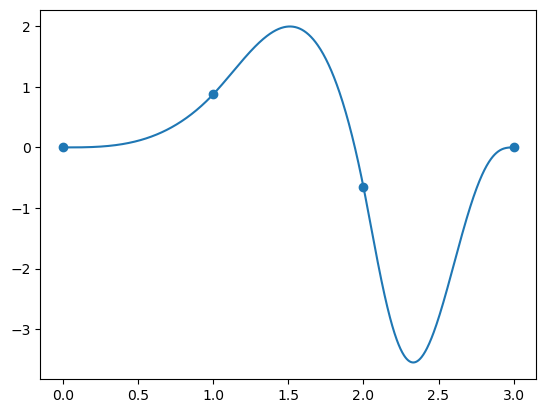

In [9]:
n_knots = 4

knots = np.linspace(0,3, n_knots)

y_knots = np.random.randn(n_knots)

y_knots[0] = 0
y_knots[-1] = 0

coef_lst = spline_fit(x_arr = knots, y_arr = y_knots, n_knots = n_knots, init_grad=np.zeros((2,)), final_grad=np.zeros((2,)))

x = np.linspace(0,3,1000)

y = spline_eval(x, coef_lst, knots)
plt.plot(x,y)

plt.scatter(knots, y_knots)

print(coef_lst)

[ 0.00000000e+00 -4.73695157e-15  6.45409652e-14  8.08109272e+00
 -1.32136576e+01  7.82626248e+00 -2.01015470e+00  1.90094997e-01]


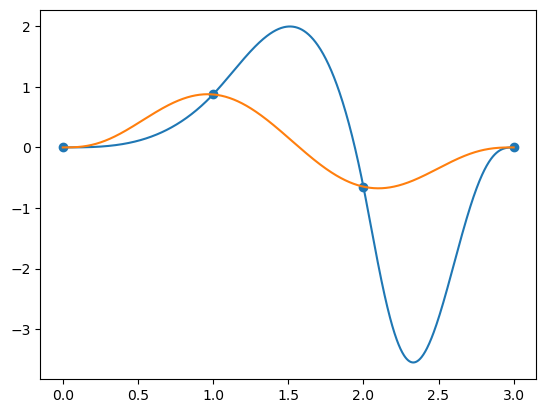

In [13]:
dof = 10

coef = polyfit(knots, y_knots, init_grad=np.zeros((2,)), final_grad=np.zeros((2,)))

print(coef)

y_hdof = polyval(x, coef = coef, dof = dof)

plt.plot(x, y)
plt.plot(x,y_hdof)
plt.scatter(knots, y_knots)


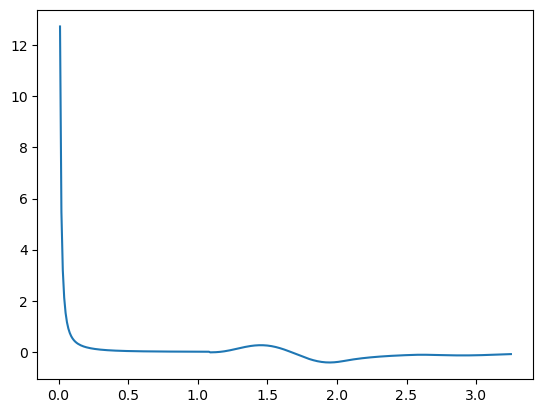

In [6]:
whe = np.loadtxt('Potentials/W-He-Juslin.table',skiprows=6)[:,1:3]

zbl_class = ZBL(74, 2)

whe[:,1] = whe[:,1] - zbl_class.eval_zbl(whe[:,0])

plt.plot(whe[:,0], whe[:,1])

dr = - whe[0,0] + whe[1,0]



Spline Time: 0.000947 s
Pure Poly Time: 0.000415 s


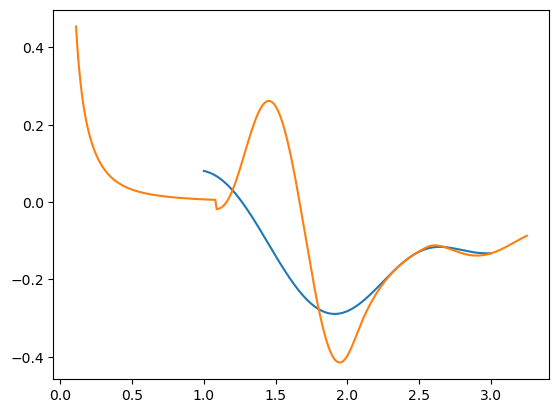

In [7]:
n_knots = 6

knots = np.linspace(0 ,3, n_knots)

idx = (knots//dr).astype(int)

y_knots = whe[idx,1]

y_knots[0] = 0

tic = time.perf_counter() 
coef_lst = spline_fit(x_arr = knots, y_arr = y_knots, n_knots = n_knots, init_grad=np.zeros((2,)), final_grad=np.zeros((2,)))
toc = time.perf_counter()

print('Spline Time: %f s' % (toc - tic))

x = np.linspace(1,3,1000)

y = spline_eval(x, coef_lst, knots)

tic = time.perf_counter()
coef = polyfit(knots, y_knots, init_grad=np.zeros((2,)), final_grad=np.zeros((2,)))
toc = time.perf_counter()

print('Pure Poly Time: %f s' % (toc - tic))

y_hdof = polyval(x, coef = coef, dof=dof)

plt.plot(x, y_hdof)
plt.plot(whe[10:,0],whe[10:,1])

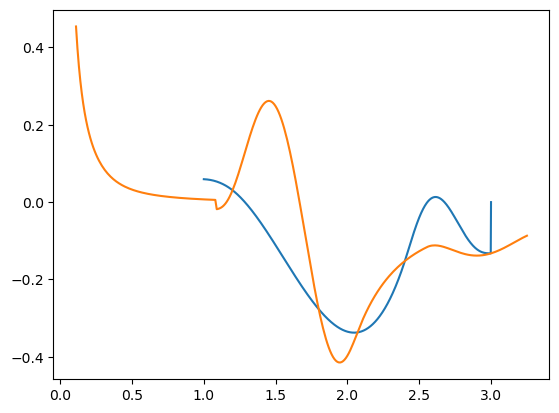

In [8]:
plt.plot(x, y)
plt.plot(whe[10:,0],whe[10:,1])